In [1]:
import tensorflow as tf 
import random 
import numpy as np 
import pandas as pd 
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
import io 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import regularizers 
from tensorflow.keras import backend as K 
K.clear_session() 

import pandas as pd

df = pd.read_csv('master_dataset.csv', sep='\t', encoding='utf-8')

df.dropna(subset = ["status", "branchetekst", "_source.Vrvirksomhed.virksomhedMetadata.nyesteBeliggenhedsadresse.kommune.kommuneNavn"], inplace=True)

df = df.replace({'Aktiv': 1})
df = df.replace({'NORMAL': 1})
df = df.replace({'OPLØST EFTER ERKLÆRING': 1})
df = df.replace({'OPLØST EFTER FRIVILLIG LIKVIDATION': 0})
df = df.replace({'OPLØST EFTER FUSION': 1})
df = df.replace({'OPLØST EFTER GRÆNSEOVERSKRIDENDE HJEMSTEDSFLYTNING': 1})
df = df.replace({'OPLØST EFTER KONKURS': 0})
df = df.replace({'OPLØST EFTER SPALTNING': 0})
df = df.replace({'SLETTET': 0})
df = df.replace({'TVANGSOPLØST': 0})
df = df.replace({'UDEN RETSVIRKNING': 0})
df = df.replace({'UNDER FRIVILLIG LIKVIDATION': 0})
df = df.replace({'UNDER KONKURS': 0})
df = df.replace({'UNDER REASSUMERING': 0})
df = df.replace({'UNDER REKONSTRUKTION': 1})
df = df.replace({'UNDER TVANGSOPLØSNING': 0})



C:\Users\ander\anaconda3\envs\BDP\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (12,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
df['date_time']=pd.to_datetime(df['_source.Vrvirksomhed.virksomhedMetadata.stiftelsesDato'], format='%Y-%m-%d')

df['Day_year'] = df['date_time'].dt.year
df['Day_month'] = df['date_time'].dt.month


In [3]:
neg = len(df[df['status'] == 0])
pos = len(df[df['status'] == 1]) 
total = df['status'].count()
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}



In [4]:
X = df.drop('status', axis=1)

y = df['status']

from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [5]:
def preprocess_text(sen):

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence
import re
X1_train = []
sentences = list(X_train["branchetekst"])
for sen in sentences:
    X1_train.append(preprocess_text(sen))

X1_test = []
sentences = list(X_test["branchetekst"])
for sen in sentences:
    X1_test.append(preprocess_text(sen))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X1_train)

X1_train = tokenizer.texts_to_sequences(X1_train)
X1_test = tokenizer.texts_to_sequences(X1_test)
word_index = tokenizer.word_index 
vocab_size = len(tokenizer.word_index) + 1

maxlen = 8

X1_train = pad_sequences(X1_train, padding='post', maxlen=maxlen)
X1_test = pad_sequences(X1_test, padding='post', maxlen=maxlen)


In [6]:
embeddings_index = {}; 
with open('cc.da.300.vec', encoding="utf-8") as f: 
    for line in f: 
        values = line.split(); 
        word = values[0]; 
        coefs = np.asarray(values[1:], dtype='float32'); 
        embeddings_index[word] = coefs; 
print(len(coefs))
 
embeddings_matrix = np.zeros((vocab_size+1, 300)); 
for word, i in word_index.items(): 
    embedding_vector = embeddings_index.get(word); 
    if embedding_vector is not None: 
        embeddings_matrix[i] = embedding_vector;

print(X1_train.shape)

300
(110030, 8)


In [7]:
X2_train_kb = X_train[['_source.Vrvirksomhed.virksomhedMetadata.nyesteVirksomhedsform.kortBeskrivelse']].values
X2_train_m = X_train[['Day_month']].values
X2_train_y = X_train[['Day_year']].values
#X2_train_m_so = X_train[['Day_month_so']].values
#X2_train_y_so = X_train[['Day_year_so']].values
X2_train_bynavn = X_train[['_source.Vrvirksomhed.virksomhedMetadata.nyesteBeliggenhedsadresse.kommune.kommuneNavn']].values

X2_test_kb = X_test[['_source.Vrvirksomhed.virksomhedMetadata.nyesteVirksomhedsform.kortBeskrivelse']].values
X2_test_m = X_test[['Day_month']].values
X2_test_y = X_test[['Day_year']].values
#X2_test_m_so = X_test[['Day_month_so']].values
#X2_test_y_so = X_test[['Day_year_so']].values
X2_test_bynavn = X_test[['_source.Vrvirksomhed.virksomhedMetadata.nyesteBeliggenhedsadresse.kommune.kommuneNavn']].values

from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
X2_train_bynavn = label_encoder.fit_transform(X2_train_bynavn)
X2_train_m = label_encoder.fit_transform(X2_train_m)
X2_train_y = label_encoder.fit_transform(X2_train_y)
X2_train_kb = label_encoder.fit_transform(X2_train_kb)

X2_test_bynavn = label_encoder.fit_transform(X2_test_bynavn)
X2_test_m = label_encoder.fit_transform(X2_test_m)
X2_test_y = label_encoder.fit_transform(X2_test_y)
X2_test_kb = label_encoder.fit_transform(X2_test_kb)

X2_train = np.dstack((X2_train_bynavn,X2_train_kb, X2_train_m, X2_train_y))
X2_test = np.dstack((X2_test_bynavn,X2_test_kb, X2_test_m, X2_test_y))

X2_train = np.reshape(X2_train, (110030,4)) 
X2_test = np.reshape(X2_test, (27508,4)) 

C:\Users\ander\anaconda3\envs\BDP\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [8]:
#minMaxScaller
from sklearn.preprocessing import MinMaxScaler
mmx = MinMaxScaler()

X2_train = mmx.fit_transform(X2_train)
X2_test = mmx.fit_transform(X2_test)

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras.models
from keras.models import Model
from keras.models import Sequential
from keras.layers import Activation, Dense
from tensorflow.keras.layers import InputLayer, Embedding, LSTM, Concatenate

In [10]:
input_1 = keras.Input(shape=(maxlen,))
input_2 = keras.Input(shape=(4,))

embedding_layer = Embedding(vocab_size+1, 300, weights=[embeddings_matrix], trainable=False)(input_1)
Model1 = LSTM(128)(embedding_layer)

dense_layer_1 = Dense(10, activation='relu')(input_2)
Model2 = Dense(10, activation='relu')(dense_layer_1)

from keras.layers import Concatenate
concat_layer = Concatenate()([Model1, Model2])
dense_layer_3 = Dense(10, activation='relu')(concat_layer)
output = Dense(1, activation='sigmoid')(dense_layer_3)
model = Model(inputs=[input_1, input_2], outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 8, 300)       328800      input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           50          input_2[0][0]                    
______________________________________________________________________________________________

In [11]:
history = model.fit(x=[X1_train, X2_train], y=y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2, class_weight=class_weight)

Epoch 1/10
688/688 [==============================] - 10s 12ms/step - loss: 0.6114 - acc: 0.6802 - val_loss: 0.5434 - val_acc: 0.7382
Epoch 2/10
688/688 [==============================] - 8s 12ms/step - loss: 0.5788 - acc: 0.7091 - val_loss: 0.5451 - val_acc: 0.7334
Epoch 3/10
688/688 [==============================] - 8s 12ms/step - loss: 0.5742 - acc: 0.7091 - val_loss: 0.5990 - val_acc: 0.7039
Epoch 4/10
688/688 [==============================] - 8s 12ms/step - loss: 0.5718 - acc: 0.7119 - val_loss: 0.5745 - val_acc: 0.7088
Epoch 5/10
688/688 [==============================] - 8s 11ms/step - loss: 0.5680 - acc: 0.7098 - val_loss: 0.5349 - val_acc: 0.7319
Epoch 6/10
688/688 [==============================] - 8s 12ms/step - loss: 0.5675 - acc: 0.7140 - val_loss: 0.5534 - val_acc: 0.7266
Epoch 7/10
688/688 [==============================] - 8s 11ms/step - loss: 0.5694 - acc: 0.7113 - val_loss: 0.5941 - val_acc: 0.6941
Epoch 8/10
688/688 [==============================] - 8s 12ms/step -

Text(0.5, 1.0, 'Loss Curves')

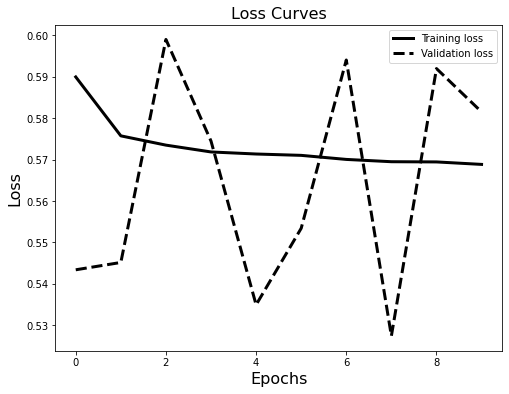

In [12]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], 'black', linewidth=3.0)
plt.plot(history.history['val_loss'], 'black', ls = '--', linewidth=3.0)
plt.legend(['Training loss', 'Validation loss'], fontsize=10)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16)

In [13]:
preds = model.predict([X1_test, X2_test])
preds.mean()
preds = np.array([1 if x >= 0.5 else 0 for x in preds])
preds

array([0, 0, 1, ..., 0, 0, 1])

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

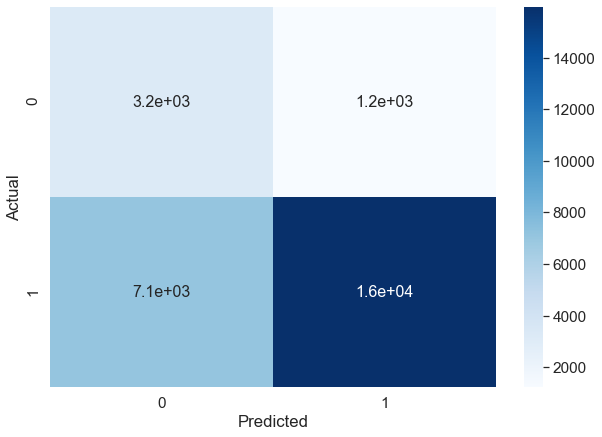

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline


data = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [15]:
data

array([[ 3213,  1225],
       [ 7098, 15972]], dtype=int64)